# Inference with classifiers

# Hypothesis-testing: simple 1D Gaussian

<hr style="border:2px solid gray">

# Index:  <a id='index'></a>
1. [Introduction](#intro)
1. [Learning the likelihood-density ratio with classifiers](#sbi_with_classifiers)
1. [Simple hypothesis test with 1D Gaussian example](#simple_hypothesis_test)

In [ ]:
# If running on Google Colab: install dependencies
!pip install numpy pandas matplotlib scikit-learn torch --quiet

<hr style="border:2px solid gray">

# 1. Introduction <a id='intro'></a>

In this notebook you will learn how to use a simple Machine Learning (ML) classifier for simulation-based inference (SBI). Let's begin by introducing what this means...

Statistical inference is a key component of the scientific method. It explains how we extract any understanding from the data we collect. As you have learnt from the lecture, the **likelihood function** holds the key to inference. 

Let's say we perform an experiment $N_{obs}$ times and observe the data set $\mathcal{D} = \{x_i\}^{N_{obs}}_{i=1}$, where $x \in \mathbb{R}^d$ is the vector of features describing the data of dimension $d$. We have a theoretical model $p(x|\theta)$, defined by parameters $\theta$, which describes the data. In order to infer the values of $\theta$ from the data, we need the (conditional) probability density: $p(x|\theta)$. The **likelihood** is then constructed as the product of the densities over the observed data:

$$ 
p(\mathcal{D}|\theta) = \prod^{N_{obs}}_{x_i \in \mathcal{D}} p(x_i|\theta) 
$$

This tells us the probability of observing dataset $\mathcal{D}$ given $\theta$. There are then two paradigms for inference:

* <u>**Frequentist inference**</u>: the interpretation here is over hypothetical repetitions of the experiment i.e. probability is the fraction of experiments under which the true value of $\theta$ would be included in the estimator’s confidence interval. For this, we construct a test-statistic $t_\theta$, and compare the observed value of the test-statistic to distributions under different values of $\theta$. The Neyman-Pearson lemma tells us that (for a simple hypothesis test) the most powerful test-statistic is the log-likelihood ratio:

    $$
    t = -2\ln{\frac{p(\mathcal{D}|\theta)}{p(\mathcal{D}|\theta_0)}}
    $$

    where $\theta_0$ is a reference value of the parameter vector $\theta$.

* <u>**Bayesian inference**</u>: the interpretation here is over degrees of belief about parameter values. We use Bayes Theorem to estimate the posterior density:

    $$
    p(\theta|\mathcal{D}) = \frac{p(\mathcal{D}|\theta)p(\theta)}{p(\mathcal{D})}
    $$

    from which we build credible intervals for parameters as a function of the data.

Both paradigms rely on the likelihood: $p(\mathcal{D}|\theta)$. This notebook has a frequentist flavour (put together by a particle physicist), but there is nothing stopping you applying these ideas in a Bayesian formalism.

## Intractable likelihoods

For many scientific domains, we are no longer in the regime of simple models with analytic (tractable) likelihoods. The systems that we are trying to model become increasingly complex with many unobserved (latent) variables, $z$. Take disease modelling over a population:

![disease_modelling](disease_modelling.png)

We need to model the effect of social mixing, mask wearing, level of caution etc (latent variables) in order to infer something meaningful about the data. 

This crucially cannot be done analytically. The likelihood becomes a complicated integral over all possible trajectories through latent space:

$$
p(\mathcal{D}|\theta) = \prod^{N_{obs}}_{x_i \in \mathcal{D}} \int dz \,p(x_i|\theta,z) 
$$

How can we approximate this intractable likelihood? Answer: **Simulation**.

We can use (stochastic) simulators to generate synthetic data under different model parameters $\theta$. These simulators are typically very complex in order to encapsulate all the underlying physics. **Simulation-based inference** (SBI) refers to the comparison of the synthetic data to the observed data, in order to infer something about $\theta$.

## Simulation-based inference

There are two traditional approaches to SBI:

* Approximate Bayesian Computation (ABC): which you have already covered.

* Probability density estimation using the simulated (synthetic) data via histogramming or kernel-density estimation.

Over recent years, scientists across many disciplines have turned to Machine Learning (ML) for SBI. The recent boom has lead to the development of a plethora of ML techniques, most of which cannot be covered in this tutorial. Instead, we will lay the foundations by showing how a simple ML classifer can be used for hypothesis testing, and later parameter estimation. This (in theory) will help you bridge the gap between your statistics and ML lectures. If you are interested and want to delve deeper into this fast-growing topic, we have added a [Further reading](#further_reading) section at the end of this notebook.

<hr style="border:2px solid gray">

# 2. Learning the likelihood ratio with classifiers <a id='sbi_with_classifiers'></a>

As mentioned in the previous section, we will show how to perform SBI with ML classifiers.

<div style="background-color:#FFCCCB">

Binary classifiers are tasked with discriminating between two hypotheses: $\mathcal{H}_0$ and $\mathcal{H}_1$. They are trained by minimising the binary cross-entropy (BCE) loss function:

$$
\mathcal{L}[f] = -\frac{1}{N} \sum^{N}_{i=1} y_i \ln{f(x_i)} + (1-y_i)\ln{(1-f(x_i))}
$$

where the sum is over $N$ samples $x_i$ drawn from the (conditional) probability densities $p(x|\mathcal{H}_0)$ or $p(x|\mathcal{H}_1)$ with assigned labels $y_i=0$ or $y_i=1$, respectively. Note, for SBI these samples are produced with the simulator.

The quantity $f(x_i)$ is the classifier decision function (i.e. the output of the classifier). The optimal decision function (in the infinite sample limit i.e. as $N \rightarrow \infty$) which minimises the (BCE) loss function is:

$$
f(x_i) = \frac{p(x_i|\mathcal{H}_1)}{p(x_i|\mathcal{H}_0)+p(x_i|\mathcal{H}_1)}
$$

assuming that the two hypotheses are equally represented in the training data. 

It is important to note that our trained classifier $\hat{f}(x_i)$ will be an estimator of the optimal decision function: $\hat{f}(x_i) \approx f(x_i)$. For a classification task, this will just lead to a mis-labelling of the data. However, for inference, it can lead to a bias in our measurement. Hence, we take great care in validating our SBI ML algorithms when applied in real-world scenarios (see [Further reading](#further_reading)).

With a simple re-arranging known as the likelihood-ratio trick [1], we arrive at an approximation of the (conditional) probability density ratio between the two hypotheses for a single sample $x_i$:

$$
\frac{\hat{f}(x_i)}{1-\hat{f}(x_i)} \approx \frac{p(x_i|\mathcal{H_1})}{p(x_i|\mathcal{H_0})}.
$$

The likelihood ratio (which is what we want for Frequentist inference) is then constructed by taking the product of the probability density ratios for all samples in the observed data set. 

$$
\frac{p(\mathcal{D}|\mathcal{H}_0)}{p(\mathcal{D}|\mathcal{H}_1)} = \prod^{N_{obs}}_{x_i \in \mathcal{D}} \frac{p(x_i|\mathcal{H_1})}{p(x_i|\mathcal{H_0})} \approx \prod^{N_{obs}}_{x_i \in \mathcal{D}} \frac{\hat{f}(x_i)}{1-\hat{f}(x_i)}
$$

Under the Neyman-Pearson lemma, the (twice negative) log-likelihood ratio provides the most powerful test-statistic for a simple hypothesis test:

$$
t = 2\Delta\mathrm{NLL} = -2 \ln{\frac{p(\mathcal{D}|\mathcal{H}_1)}{p(\mathcal{D}|\mathcal{H}_0)}} \approx -2 \sum^{N_{obs}}_{x_i \in \mathcal{D}} \ln{\bigg(\frac{\hat{f}(x_i)}{1-\hat{f}(x_i)}\bigg)}
$$

We can use this "learned" test-statistic to perform a hypothesis test!

</div>

In summary, we first showed how the output of a classifier can be used to approximate the probability density ratio between two hypotheses for a single sample, $x_i$. This can then be used to define a test-statistic over a full dataset. We will now show how to use the test-statistic for inference by performing a hypothesis test. This is something that you have already seen in your statistics lectures. We will begin with a simple example where the analytic likelihood is known and compare to the performance of the "learned" test-statistic.

[1] - K. Cranmer, J. Pavez and G. Louppe, *Approximating Likelihood Ratios with Calibrated Discriminative Classifiers* (2016). [arXiv:1506.02169](https://arxiv.org/abs/1506.02169)


<hr style="border:2px solid gray">

# 3. Simple hypothesis test  <a id='simple_hypothesis_test'></a>

Let's show how to use a binary classifier to perform a two-class hypothesis test for a simple problem. You will use your knowledge of hypothesis testing from the statistics lectures. The problem is as follows:

* There are two possible hypotheses (classes) to explain the data. Data produced from the classes have one observable $x$ which is distributed according to a 1D Gaussian with unit width. Class 0 has a mean of zero, and class 1 has a mean of one. We will define class 0 as the null hypothesis ($\mathcal{H}_0$), and class 1 as the alternative hypothesis ($\mathcal{H}_1$).
* An experiment is performed in which $x$ is measured for $N_{obs}=10$ independent samples. The observed data are provided in the file `data_simple.csv`.
* We are going to set up a hypothesis test to infer which class the data belong to. We will first demonstrate how to do this using the analytic likelihood, where we will use the log-likelihood ratio as a test-statistic. Following this we will show how to learn the log-likelihood ratio from simulated samples (synthetic data) using machine learning. 
* We will then compare the performance of the two approaches.

Obviously, SBI is overkill for this simple problem where the analytic likelihood is known. We will show in [Section 4](#complex_hypothesis_test) how one can extend this to a more complex problem (with an unknown likelihood) to perform inference on the data.

Let's begin by importing the relevant libraries and defining the function used to generate synthetic data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Function to generate 1D gaussian synthetic data (x)
def generate_synthetic_data(num_samples, loc, scale, seed=42):
    np.random.seed(seed)
    data = np.random.normal(loc=loc, scale=scale, size=num_samples)
    return pd.DataFrame(data, columns=['x'])

We will now generate synthetic data from each of the two hypotheses. These are subsequently combined into a single dataframe which will later use to train the classifier.

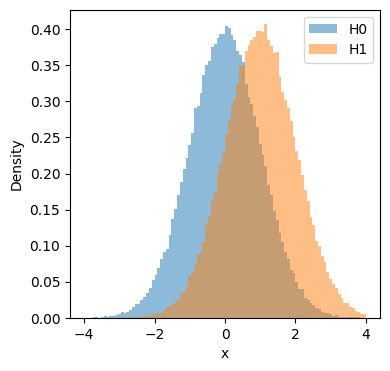

In [2]:
num_train_per_class = 100000
# Generate synthetic training data for two classes
train_H0 = generate_synthetic_data(num_train_per_class, loc=0, scale=1)
train_H0['label'] = 0
train_H1 = generate_synthetic_data(num_train_per_class, loc=1, scale=1)
train_H1['label'] = 1
train_data = pd.concat([train_H0, train_H1]).reset_index(drop=True)

# Plot histograms of the synthetic training data
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(train_H0['x'], bins=100, range=(-4,4), alpha=0.5, label='H0', density=True)
ax.hist(train_H1['x'], bins=100, range=(-4,4), alpha=0.5, label='H1', density=True)
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.legend(loc='best')
plt.show()

The observed data is stored in `data_simple.csv`. Let's plot the observed data on top of the expected distributions for the two classes.

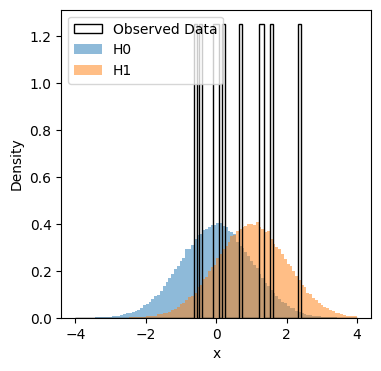

In [3]:
# Load the data from csv file
data_obs = pd.read_csv('data_simple.csv')
N_obs = len(data_obs)

# Plot histogram of the observed data
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(data_obs['x'], bins=100, range=(-4,4), color='black', histtype='step', label='Observed Data', density=True)
ax.hist(train_H0['x'], bins=100, range=(-4,4), alpha=0.5, label='H0', density=True)
ax.hist(train_H1['x'], bins=100, range=(-4,4), alpha=0.5, label='H1', density=True)
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.legend(loc='upper left')
plt.show()

Can you tell by eye which class the observed data belong to? In any case, let's perform a proper hypothesis test. We will start with the analytic solution.

## Analytic likelihood-ratio
<div style="background-color:#FFCCCB">

The probability of observation $x_i$ is given by the following formula, assuming $x$ follows a Gaussian distribution with mean $\mu$ and width $\sigma$ is:

$$
p(x_i|\mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{(x_i-\mu)^2}{2\sigma^2}}
$$

Therefore, the likelihood over dataset $\mathcal{D} = \{x_i\}$ of $N_{obs}$ samples is:

$$
p(\mathcal{D}|\mu,\sigma) = \prod^{N_{obs}}_{x_i \in \mathcal{D}} p(x_i|\mu,\sigma)
$$

As discussed above, the Neyman-Pearson lemma tells us that the log-likelihood ratio is the most powerful test-statistic for simple hypothesis testing ($\mathcal{H}_0$ vs $\mathcal{H}_1$). We will use $2\Delta\mathrm{NLL}$ as convention for the choice of test-statistic: 

$$
t = 2\Delta\mathrm{NLL} = -2 \ln {\frac{p(\mathcal{D}|\mathcal{H}_1)}{p(\mathcal{D}|\mathcal{H}_0)}}
$$
</div>
Do you know why we use the "twice-negative" as convention? The answer lies in **Wilk's theorem**: the twice-negative log-likelihood ratio asymptotically approaches the $\chi^2$ distribution under the null hypothesis. This means we can use the properties of the $\chi^2$ function to determine the probability distribution of the test-statistic, and subsequently the coverage/confidence intervals. Anyway we will come to this in the parameter estimation section.

Let's code this up...

In [4]:
# Function to calculate log-likelihood ratio between two hypotheses with (mu0, sigma0) vs (mu1, sigma1)
def log_likelihood_ratio(x, mu0=0, mu1=1, sigma0=1, sigma1=1):
    ll_H0 = -0.5 * ((x - mu0) / sigma0)**2 - np.log(sigma0) - 0.5 * np.log(2 * np.pi)
    ll_H1 = -0.5 * ((x - mu1) / sigma1)**2 - np.log(sigma1) - 0.5 * np.log(2 * np.pi)
    return ll_H1 - ll_H0

# Function to calculate test statistic (2NLL) over all events 
def test_statistic(x, mu0=0, mu1=1, sigma0=1, sigma1=1):
    llr = log_likelihood_ratio(x, mu0, mu1, sigma0, sigma1)
    return -2 * np.sum(llr)

To perform a hypothesis test we need to first generate synthetic datasets (toys) which are representative of the observed data ($N_{obs}=10$), under each hypothesis. For each "toy" we will calculate the value of the test statistic, building up a distributions of the test statistic under the two hypotheses.

We then calculate the test-statistic value for the observed data, and compare this to the distributions.

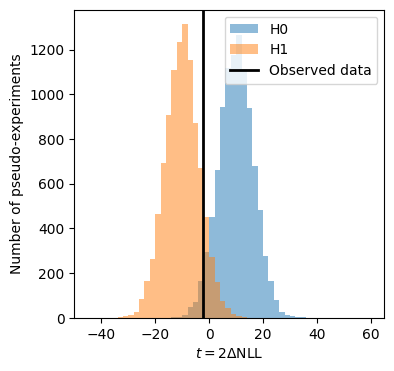

In [5]:
N_toys = 10000
test_statistic_H0 = []
test_statistic_H1 = []
for _ in range(N_toys):
    # Samples under H0
    samples_H0 = generate_synthetic_data(N_obs, loc=0, scale=1, seed=None)
    t_H0 = test_statistic(samples_H0['x'], mu0=0, mu1=1, sigma0=1, sigma1=1)
    test_statistic_H0.append(t_H0)

    # Samples under H1
    samples_H1 = generate_synthetic_data(N_obs, loc=1, scale=1, seed=None)
    t_H1 = test_statistic(samples_H1['x'], mu0=0, mu1=1, sigma0=1, sigma1=1)
    test_statistic_H1.append(t_H1)

# Calculate observed test statistic
t_obs = test_statistic(data_obs['x'], mu0=0, mu1=1, sigma0=1, sigma1=1)

# Plot the distributions of the test statistic under both hypotheses, as well as the observed case
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(test_statistic_H0, bins=50, alpha=0.5, range=(-50,50), label='H0')
ax.hist(test_statistic_H1, bins=50, alpha=0.5, range=(-50,50), label='H1')
ax.axvline(t_obs, color='black', linestyle='solid', linewidth=2, label='Observed data')
ax.set_xlabel('$t = 2\\Delta$NLL')
ax.set_xlim(-50, 65)
ax.set_ylabel('Number of pseudo-experiments')
ax.legend(loc='best')


From the test-statistic distributions we can calculate the $p$-value with respect to the null hypothesis ($\mathcal{H}_0$) by integrating the left-hand tail of the $\mathcal{H}_0$ distribution up to the observed value of the test-statistic. This $p$-value tells us:
* Assuming $\mathcal{H}_0$ is true, what is the probability of obtaining data at least as extreme as what you observed, over a long run of repeated identical experiments.

If the $p$-value is below some pre-defined critical threshold ($\alpha=0.05$), then we can reject the null-hypothesis at the $1-\alpha$ confidence level (CL). 

We can calculate the Type-1 and Type-2 error rate for fixed $\alpha$ and subsequently the power of the test. The error rates are defined as follows:
* Type-1: assuming $\mathcal{H}_0$ is true, it is the probability of incorrectly rejecting $\mathcal{H}_0$ ($=\alpha$) i.e. false positive rate.
* Type-2: assuming $\mathcal{H}_1$ is true, it is the probability of incorrectly failing to reject $\mathcal{H}_0$ ($\beta$) i.e. it quantifies the fraction of the $\mathcal{H}_1$ distribution which lies beyond the critical value. In this way ($1-\beta$) is equal to the true positive rate (which is also referred to as the statistical power). 

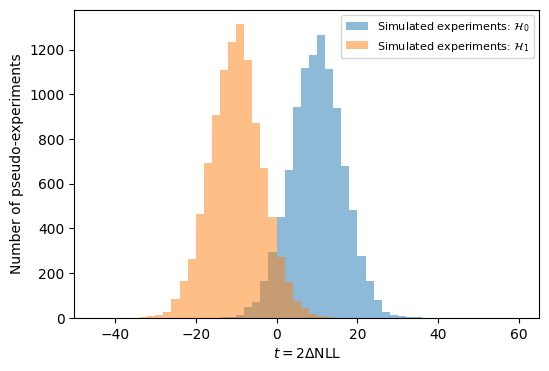

In [6]:
# Calculate the p-value for H0
p_value_H0 = np.sum(np.array(test_statistic_H0) <= t_obs) / N_toys

# Calculate the type-1 and type-2 errors and the statistical power for fixed alpha=0.05
alpha = 0.05
type_1_error = alpha
critical_value = np.percentile(test_statistic_H0, alpha * 100)
type_2_error = np.sum(np.array(test_statistic_H1) > critical_value) / N_toys
power = 1 - type_2_error    

# Plot results again with additional annotations
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(test_statistic_H0, bins=50, alpha=0.5, range=(-50,50), label='Simulated experiments: $\mathcal{H}_0$')
ax.hist(test_statistic_H1, bins=50, alpha=0.5, range=(-50,50), label='Simulated experiments: $\mathcal{H}_1$')
#ax.axvline(t_obs, color='black', linestyle='solid', linewidth=2, label='Observed data ($p$={:.3f})'.format(p_value_H0))
#ax.axvline(critical_value, color='red', linestyle='dashed', linewidth=2, label='Critical value (α={})'.format(alpha))
ax.set_xlabel('$t = 2\\Delta$NLL')
ax.set_xlim(-50, 65)
ax.set_ylabel('Number of pseudo-experiments')
ax.legend(loc='best', fontsize=8)
# Add text to plot with type-1, type-2 errors and power
textstr = '\n'.join((
    'Type-1 error ($\\alpha$): {:.3f}'.format(type_1_error),
    'Type-2 error ($\\beta$): {:.3f}'.format(type_2_error),
    'Power (1-$\\beta$): {:.3f}'.format(power)))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=6,
#        verticalalignment='top', bbox=props)
plt.show()


Our $p$-value is less than the critical value ($\alpha=0.05$). We can reject the null hypothesis $\mathcal{H}_0$ for this data at the 95% CL.

We can also calculate a compatibility $p$-value with respect to the alternative hypothesis $\mathcal{H}_1$. What we want to know is "how extreme is the observed data compared to what I would expect under $\mathcal{H}_1$? Since large values of the test-statistic look more like $\mathcal{H}_0$, then here it is flipped i.e. is it the upper tail of the $\mathcal{H}_1$ distribution which indicates the incompatibility with $\mathcal{H}_1$. 

Let's calculate this quantity:

In [7]:
# Calculate p-value for alternative hypothesis
p_value_H1 = np.sum(np.array(test_statistic_H1) >= t_obs) / N_toys

# Print p-values for both hypotheses
print('P-value for H0: {:.5f}'.format(p_value_H0))
print('P-value for H1: {:.5f}'.format(p_value_H1))

P-value for H0: 0.02600
P-value for H1: 0.11430


The data is much more compatible with the alternative hypothesis! Note this might not always be the case i.e. you may have two hypotheses, neither of which fit the data well. Under this scenario one should look towards forming a different hypothesis.

A ROC curve tells us the trade-off between the Type-I error rate (false positives) and the 1 - Type-II error rate (true positives). We move the threshold ($\alpha$) and calculate $1-\beta$, as shown in the code block below. The area-under-curve (AUC) metric is a measure of how well the test statistic separates the $\mathcal{H}_0$ and $\mathcal{H}_1$ distributions i.e. the power of the test.

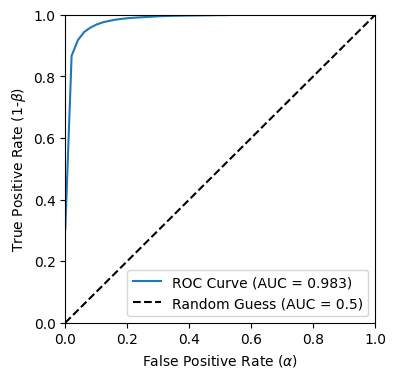

In [8]:
alpha_vals = np.linspace(0.0, 1.0, 50)
beta_vals = []
for alpha in alpha_vals:
    critical_value = np.percentile(test_statistic_H0, alpha * 100)
    type_2_error = np.sum(np.array(test_statistic_H1) > critical_value) / N_toys
    beta_vals.append(type_2_error)

fpr = alpha_vals
tpr = 1 - np.array(beta_vals)

# Calculate AUC using trapezoidal rule
auc = np.trapezoid(tpr, fpr)

# Plot the ROC curve (beta vs alpha)
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(auc))
ax.plot([0, 1], [0, 1], color='black', linestyle='dashed', label='Random Guess (AUC = 0.5)')
ax.set_xlabel('False Positive Rate ($\\alpha$)')
ax.set_ylabel('True Positive Rate (1-$\\beta$)')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend(loc='best')
plt.show()

## Learning the likelihood-ratio

As discussed in [Section 2](#sbi_with_classifiers) we can use a binary classifier to approximate the likelihood ratio. 

In this simple 1D example we will use <u>**logistic regression**</u>. Logistic regression is a simple linear classifer: it passes a linear (weighted) sum of the obvservable(s) through a sigmoid function, to map any number to a probability that the sample belongs to $\mathcal{H}_0$ or $\mathcal{H}_1$. By minimising the loss in training, we find the optimal weights for each observable. More information can be found in [1]. 

Note, the SBI approach extends to more complicated classifier architectures (e.g. BDTs, neural networks), which become useful when dealing with more complex inference problems i.e. higher dimensions, more complicated features.

[1] - Hastie, T. et al, "The Elements of Statistical Learning", Section 4.4 [Link](https://www.sas.upenn.edu/~fdiebold/NoHesitations/BookAdvanced.pdf)

In [9]:
# Train a logistic regression classifier to distinguish between H0 and H1
clf = LogisticRegression(solver='liblinear')
X_train = train_data[['x']].values
y_train = train_data['label'].values.astype(int)
# Fit classifier with BCE loss
clf.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

After the classifier $\hat{f}(x)$ has been trained, we can examine the output. Let's first generate independent simulation samples under the two hypotheses. We can then compare the classifier output score distribution from the simulation, to that of the observed data.

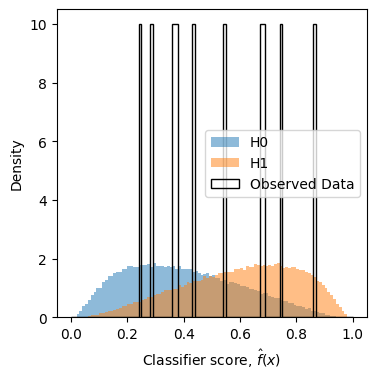

In [10]:
# Evaluate classifier scores on independent test data from the two classes
num_test_per_class = 100000
test_H0 = generate_synthetic_data(num_test_per_class, loc=0, scale=1)
test_H1 = generate_synthetic_data(num_test_per_class, loc=1, scale=1)
scores_H0 = clf.predict_proba(test_H0[['x']].values)[:, 1]
scores_H1 = clf.predict_proba(test_H1[['x']].values)[:, 1]

# Evaluate classifier scores on observed data
scores_obs = clf.predict_proba(data_obs[['x']].values)[:, 1]

# Plot histograms of the classifier scores
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(scores_H0, bins=100, range=(0,1), alpha=0.5, label='H0', density=True)
ax.hist(scores_H1, bins=100, range=(0,1), alpha=0.5, label='H1', density=True)
ax.hist(scores_obs, bins=100, range=(0,1), color='black', histtype='step', label='Observed Data', density=True)
ax.set_xlabel('Classifier score, $\\hat{f}(x)$')
ax.set_ylabel('Density')
ax.legend(loc='best')
plt.show()

Does the observed classifier score distribution help identify the correct hypothesis? Let's do the full test...

<div style="background-color:#FFCCCB">

Using the likelihood-ratio trick, the classifier output can be converted to the density ratio:

$$
\frac{\hat{f}(x_i)}{1-\hat{f}(x_i)} \approx \frac{p(x_i|\mathcal{H}_1)}{p(x_i|\mathcal{H}_0)}
$$

With this, we can approximate the test-statistic over the full ($N_{obs}=10$) dataset ($\mathcal{D}$):

$$
t \approx -2  \sum^{N_{obs}}_{x_i \in \mathcal{D}} \ln{\bigg(\frac{\hat{f}(x_i)}{1-\hat{f}(x_i)}\bigg)}
$$

</div>

In the same way as the analytic approach, we will write python functions to calculate the log-likelihood ratio and the test-statistic. These functions evaluate the classifier on input data $\{x_i\} \in \mathcal{D}$, convert the classifier output to the log-likelihood-ratio per sample, and then calculate the test-statistic over the dataset by summing the values and multiplying by -2. Note, we clip the classifier output scores to avoid log(0) in the calculation.

In [11]:
def log_likelihood_ratio_clf(x, clf, clip=1e-10):
    scores = clf.predict_proba(x.reshape(-1, 1))[:, 1]
    # Avoid log(0) by clipping scores
    scores = np.clip(scores, clip, 1-clip)
    llr = np.log(scores / (1 - scores))
    return llr

def test_statistic_clf(x, clf):
    llr = log_likelihood_ratio_clf(x, clf)
    return -2 * np.sum(llr)

With this we can perform the same hypothesis-testing procedure but now using the learned test-statistic. Let's generate toy datasets under each hypothesis with $N_{obs}=10$. For each toy we will calculate the analytic and learned test-statistic values, building up distributions of each under the two hypotheses. We can then calculate the analytic and learned test-statistic values for the observed dataset, and calculate the $p$-values with respect to the null hypothesis.

We will also compare the statistical power of each hypothesis test.

In [12]:
N_toys = 10000
test_statistic_H0_clf = []
test_statistic_H1_clf = []
test_statistic_H0_analytic = []
test_statistic_H1_analytic = []
for _ in range(N_toys):
    # Samples under H0
    samples_H0 = generate_synthetic_data(N_obs, loc=0, scale=1, seed=None)
    t_H0_clf = test_statistic_clf(samples_H0['x'].values, clf)
    t_H0_analytic = test_statistic(samples_H0['x'], mu0=0, mu1=1, sigma0=1, sigma1=1)
    test_statistic_H0_clf.append(t_H0_clf)
    test_statistic_H0_analytic.append(t_H0_analytic)

    # Samples under H1
    samples_H1 = generate_synthetic_data(N_obs, loc=1, scale=1, seed=None)
    t_H1_clf = test_statistic_clf(samples_H1['x'].values, clf)
    t_H1_analytic = test_statistic(samples_H1['x'], mu0=0, mu1=1, sigma0=1, sigma1=1)
    test_statistic_H1_clf.append(t_H1_clf)
    test_statistic_H1_analytic.append(t_H1_analytic)

# Calculate observed test statistic
t_obs_clf = test_statistic_clf(data_obs['x'].values, clf)
t_obs_analytic = test_statistic(data_obs['x'], mu0=0, mu1=1, sigma0=1, sigma1=1)

In [13]:
# Calculate the p-values for H0
p_value_H0_clf = np.sum(np.array(test_statistic_H0_clf) <= t_obs_clf) / N_toys
p_value_H0_analytic = np.sum(np.array(test_statistic_H0_analytic) <= t_obs_analytic) / N_toys

# Calculate the type-1 and type-2 errors for fixed alpha=0.05
alpha = 0.05
type_1_error = alpha
critical_value_clf = np.percentile(test_statistic_H0_clf, alpha * 100)
critical_value_analytic = np.percentile(test_statistic_H0_analytic, alpha * 100)
type_2_error_clf = np.sum(np.array(test_statistic_H1_clf) > critical_value_clf) / N_toys
type_2_error_analytic = np.sum(np.array(test_statistic_H1_analytic) > critical_value_analytic) / N_toys
power_clf = 1 - type_2_error_clf
power_analytic = 1 - type_2_error_analytic

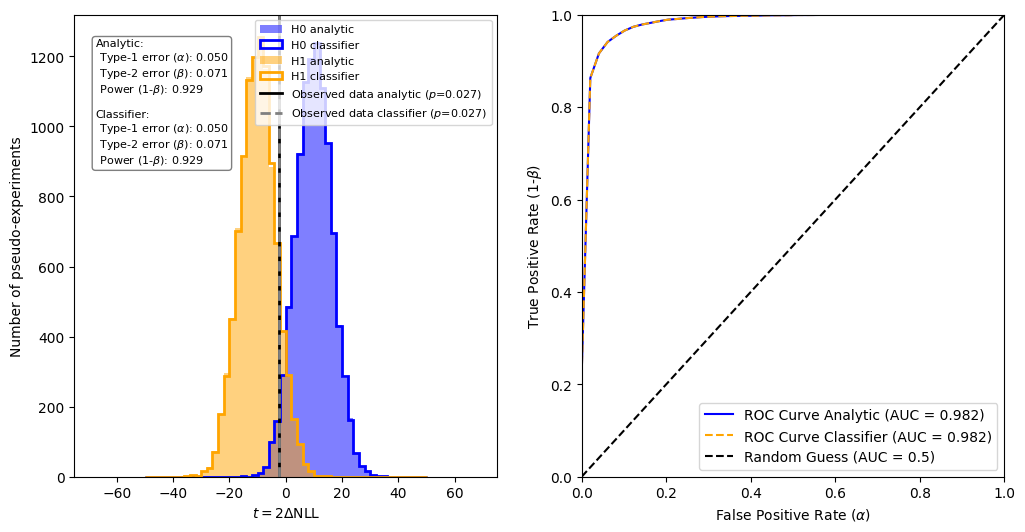

In [14]:
# Plot results: compare analytic vs classifier-based test statistics
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].hist(test_statistic_H0_analytic, bins=50, alpha=0.5, range=(-50,50), label='H0 analytic', color='blue')
ax[0].hist(test_statistic_H0_clf, bins=50, range=(-50,50), label='H0 classifier', color='blue', histtype='step', linewidth=2)
ax[0].hist(test_statistic_H1_analytic, bins=50, alpha=0.5, range=(-50,50), label='H1 analytic', color='orange')
ax[0].hist(test_statistic_H1_clf, bins=50, range=(-50,50), label='H1 classifier', color='orange', histtype='step', linewidth=2)
ax[0].axvline(t_obs_analytic, color='black', linestyle='solid', linewidth=2, label='Observed data analytic ($p$={:.3f})'.format(p_value_H0_analytic))
ax[0].axvline(t_obs_clf, color='grey', linestyle='dashed', linewidth=2, label='Observed data classifier ($p$={:.3f})'.format(p_value_H0_clf))

ax[0].set_xlabel('$t = 2\\Delta$NLL')
ax[0].set_xlim(-75, 75)
ax[0].set_ylabel('Number of pseudo-experiments')
ax[0].legend(loc='upper right', fontsize=8)

# Add text to plot with type-1, type-2 errors and power for both methods
textstr = '\n'.join((
    'Analytic:',
    ' Type-1 error ($\\alpha$): {:.3f}'.format(type_1_error),
    ' Type-2 error ($\\beta$): {:.3f}'.format(type_2_error_analytic),
    ' Power (1-$\\beta$): {:.3f}'.format(power_analytic),
    '',
    'Classifier:',
    ' Type-1 error ($\\alpha$): {:.3f}'.format(type_1_error),
    ' Type-2 error ($\\beta$): {:.3f}'.format(type_2_error_clf),
    ' Power (1-$\\beta$): {:.3f}'.format(power_clf)))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax[0].text(0.05, 0.95, textstr, transform=ax[0].transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

# Plot ROC curves for both methods
alpha_vals = np.linspace(0.0, 1.0, 50)
beta_vals_analytic = []
beta_vals_clf = []
for alpha in alpha_vals:
    critical_value_analytic = np.percentile(test_statistic_H0_analytic, alpha * 100)
    type_2_error_analytic = np.sum(np.array(test_statistic_H1_analytic) > critical_value_analytic) / N_toys
    beta_vals_analytic.append(type_2_error_analytic)

    critical_value_clf = np.percentile(test_statistic_H0_clf, alpha * 100)
    type_2_error_clf = np.sum(np.array(test_statistic_H1_clf) > critical_value_clf) / N_toys
    beta_vals_clf.append(type_2_error_clf)

fpr = alpha_vals
tpr_analytic = 1 - np.array(beta_vals_analytic)
tpr_clf = 1 - np.array(beta_vals_clf)

# Calculate AUC using trapezoidal rule
auc_analytic = np.trapezoid(tpr_analytic, fpr)
auc_clf = np.trapezoid(tpr_clf, fpr)

# Plot the ROC curve (beta vs alpha) for both methods
ax[1].plot(fpr, tpr_analytic, label='ROC Curve Analytic (AUC = {:.3f})'.format(auc_analytic), color='blue')
ax[1].plot(fpr, tpr_clf, label='ROC Curve Classifier (AUC = {:.3f})'.format(auc_clf), color='orange', linestyle='dashed')
ax[1].plot([0, 1], [0, 1], color='black', linestyle='dashed', label='Random Guess (AUC = 0.5)')
ax[1].set_xlabel('False Positive Rate ($\\alpha$)')
ax[1].set_ylabel('True Positive Rate (1-$\\beta$)')
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1)
ax[1].legend(loc='best')
plt.show()



## Summary
We have "learned" a test-statistic which is essentially identical to the analytic solution. Instead, this was derived using a simple logistic regression binary classifier. We have shown how to use the output of this classifier to perform a full hypothesis tests. The observed data is inconsistent with the null hypothesis ($\mathcal{H}_0$), with a $p$-value of less than 0.05. Therefore, under the two-class scenario, we conclude that the observed data support the $\mathcal{H}_1$ hypothesis. 

In this simple 1D Gaussian example, we were able to use the analytic solution as a point of comparison. For most real-world scenarios, we do not have the analytic likelihood. In the next section, we will explore an example in which the analytic likelihood is not known.